First load in all of the necessary packages.

In [ ]:
pip install oandapyV20

In [ ]:
pip install statsmodels --upgrade


Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
import pandas as pd
import random
import numpy as np
from sklearn import linear_model
import scipy as sp
import time
import cvxopt
import matplotlib.pyplot as plt
import networkx as nx
from dateutil import parser
from pandas.plotting import lag_plot
import oandapyV20
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
client = oandapyV20.API(access_token="d4902ea675170b9f8506b2967e8c6f22-10aaf3f544a24aa91c6de6fec7ba293c")

In [ ]:
# Helper functions for csv:

# Read csv and return pandas df.
# Input: path, path of csv. This csv should have first column as timestamps; 
#        columns: list, if unspecified then will use the first row of csv, otherwise assume no header in csv and use columns as the columns of the returned df
#        usecols: list of str, columns that would like to be read.
# Output: pandas df, with columns as columns and first column as index
def read_csv(path, columns = 0, usecols = None):
    if columns != 0:
        if usecols is not None:
            return pd.read_csv(path, names=columns, header=None, parse_dates=[0], index_col = 0, usecols=[columns[0]] + usecols)
        return pd.read_csv(path, names=columns, header=None, parse_dates=[0], index_col = 0)
    if usecols is not None:
        return pd.read_csv(path, header = columns, parse_dates=[0], index_col = 0, usecols=[columns[0]] + usecols)
    return pd.read_csv(path, header = columns, parse_dates=[0], index_col = 0)

# Write csv to path.
def to_csv(path, df):
    df.to_csv(path)

# Class of currency history price. Each instance represents a currency pair 'XXX_YYY' with its history bid, ask price
class Curncy_Hist_PX:
    
    # Keeps track of created instances in this subclass
    fx_list = []
    inst_dict = {}
    
    # Instance init function. Get price data and creates instance of currency pair history price.
    # Inputs: base_curncy: str of base currency in form 'XXX'; quote_curncy: str of quote currency in form 'YYY'
    # Outputs: None
    # Attributes: name: str, in form 'XXX_YYY'; 
    #             bid_px, ask_px: all np array;
    #             px_time: np array, timestamps corresponding to the above prices
    # Needs to be modified if one would like to change the data source.
    def __init__(self, base_curncy, quote_curncy):
        
        curncy_name = '_'.join([base_curncy,quote_curncy])
        
        # Case: base_curncy == quote_curncy. No query, all rates are 1.
        if base_curncy == quote_curncy:
            self.name = curncy_name
            _, _, self.px_time = self.get_hist_px('EUR_USD')
            self.bid_px = np.ones(np.shape(self.px_time)[0])
            self.ask_px = np.ones(np.shape(self.px_time)[0])
            if base_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(base_curncy)
            Curncy_Hist_PX.inst_dict[curncy_name] = {'Base': base_curncy, 'Quote': quote_curncy, 'Object': self}
            
        else:
            # Case: can query product 'base_curncy'_'quote_curncy'
            try:
                self.name = curncy_name
                self.bid_px, self.ask_px, self.px_time = self.get_hist_px(self.name)
                if base_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(base_curncy)
                if quote_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(quote_curncy)
                Curncy_Hist_PX.inst_dict[curncy_name] = {'Base': base_curncy, 'Quote': quote_curncy, 'Object': self}
                print("Got {curncy} price using {curncy}".format(curncy=self.name))
                
            except (V20Error, KeyError):
                # Case: can query the reverse product 'quote_curncy'_'base_curncy'. Bid and ask prices are switched and then taken the inverse. 
                # Example: 'JPY_USD' may not be an existing product in many data sources, since the prices are too small.
                #          However it is possible to query from 'USD_JPY', which is equivalent up to switching bid and ask prices. 
                try:
                    self.name = curncy_name
                    rev_name = '_'.join([quote_curncy,base_curncy])
                    rev_bid_px, rev_ask_px, self.px_time = self.get_hist_px(rev_name)
                    self.bid_px = 1./rev_ask_px
                    self.ask_px = 1./rev_bid_px
                    if base_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(base_curncy) 
                    if quote_curncy not in Curncy_Hist_PX.fx_list: Curncy_Hist_PX.fx_list.append(quote_curncy)
                    Curncy_Hist_PX.inst_dict[curncy_name] = {'Base': base_curncy, 'Quote': quote_curncy, 'Object': self}
                    print("Got {curncy} price using {rev_curncy}".format(curncy=curncy_name,rev_curncy=rev_name))

                except:
                    raise ValueError("Was not able to get price for {curncy}".format(curncy=curncy_name))
    
    # The following methods are high level query methods. Do not need to be changed if need to change data source.
    
    # Returns the instance of a pair by its base_curncy name and quote_curncy name. If it does not exist, create it.
    # Inputs: base_curncy: str of base currency in form 'XXX'; quote_curncy: str of quote currency in form 'YYY'
    # Outputs: class instance
    @classmethod
    def query(cls, base_curncy, quote_curncy):
        inst_name = '_'.join([base_curncy,quote_curncy])
        if inst_name in cls.inst_dict:
            return cls.inst_dict[inst_name]['Object']
        else:
            return cls(base_curncy, quote_curncy)
    
    # Query bid price of a pair as np array by its base_curncy name and quote_curncy name
    # Inputs: base_curncy: str of base currency in form 'XXX'; quote_curncy: str of quote currency in form 'YYY'
    # Outputs: pandas df, size: (num_timestamps, 1), data: prices, index: the timestamps corresponding to the prices, columns: instrument name, ie 'base_curncy'_'quote_curncy'.
    @classmethod
    def query_bid_as_df(cls, base_curncy, quote_curncy):
        inst_name = '_'.join([base_curncy,quote_curncy])
        inst_object = cls.query(base_curncy, quote_curncy)
        bid_px_df = pd.DataFrame(data=inst_object.bid_px, index=inst_object.px_time,columns=[inst_name])
        bid_px_df_copy = bid_px_df.copy()
        return bid_px_df_copy
    
    # Query all bid prices between all recorded single currency as df.
    # Example: If we have previously only created instances of 'EUR_USD' and 'GBP_JPY', this function will return 16 prices between 'EUR', 'USD', 'GBP', 'JPY'
    # For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
    # Inputs: time_steps: int, if provided, then will only return the latest time_steps prices. csv_path: if provided, will write a csv file at path. 
    # Outputs: pandas df, size: (num_timestamps, num_curncy_pairs), data: prices, index: the timestamps corresponding to the prices, columns: list of all instrument names, ie all 'base_curncy'_'quote_curncy'.
    @classmethod
    def query_database_as_df(cls, time_steps=None, csv_path = None):
        master_df = pd.DataFrame()
        for curncy_1 in cls.fx_list:
            for curncy_2 in cls.fx_list:
                df = cls.query_bid_as_df(curncy_1,curncy_2)
                master_df = master_df.join(df,how='outer',sort=True)
        master_df.dropna(axis=0,inplace=True)
        if time_steps:
            if csv_path:
                to_csv(csv_path, master_df[-time_steps:])
            return master_df[-time_steps:]
        else:
            if csv_path:
                to_csv(csv_path, master_df)
            return master_df
    
    # Only query USD_XXX as df.
    # Example: If we have previously only created instances of 'EUR_USD' and 'GBP_JPY', this function will return 4 prices between 'USD' and 'EUR', 'USD', 'GBP', 'JPY'
    # Inputs: time_steps: int, if provided, then will only return the latest time_steps prices. csv_path: if provided, will write a csv file at path.
    # Outputs: pandas df, size: (num_timestamps, num_curncy), data: prices, index: the timestamps corresponding to the prices, columns: list of all instrument names, ie all 'USD'_'quote_curncy'.
    @classmethod
    def query_database_usd_px_as_df(cls, time_steps=None, csv_path = None):
        master_df = pd.DataFrame()
        for curncy_2 in cls.fx_list:
            df = cls.query_bid_as_df('USD',curncy_2)
            master_df = master_df.join(df,how='outer',sort=True)
        master_df.dropna(axis=0,inplace=True)
        if time_steps:
            if csv_path:
                to_csv(csv_path + '_USD_Only', master_df[-time_steps:])
            return master_df[-time_steps:]
        else:
            if csv_path:
                to_csv(csv_path + '_USD_Only', master_df)
            return master_df
    
    # Query all bid prices with commission as df.
    # Example: If we have previously only created instances of 'EUR_USD' and 'GBP_JPY', this function will return 16 prices with commission between 'EUR', 'USD', 'GBP', 'JPY'
    # For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
    # Inputs: time_steps: int, if provided, then will only return the latest time_steps prices; commission: float, amount of commission, all bid prices are multiplied by (1 - commission). csv_path: if provided, will write a csv file at path.
    # Outputs: pandas df, size: (num_timestamps, num_curncy_pairs), data: prices with commission, index: the timestamps corresponding to the prices, columns: list of all instrument names, ie all 'base_curncy'_'quote_curncy'.
    @classmethod
    def query_database_as_df_with_commission(cls, time_steps=None, commission=0, csv_path = None):
        master_df = pd.DataFrame()
        for curncy_1 in cls.fx_list:
            for curncy_2 in cls.fx_list:
                df = cls.query_bid_as_df(curncy_1,curncy_2)
                if curncy_1 != curncy_2:
                    df[:] *= (1 - commission)
                master_df = master_df.join(df,how='outer',sort=True)
        master_df.dropna(axis=0,inplace=True)
        if time_steps:
            if csv_path:
                to_csv(csv_path + '_with_' + str(commission) + '_Commission', master_df[-time_steps:])
            return master_df[-time_steps:]
        else:
            if csv_path:
                to_csv(csv_path + '_with_' + str(commission) + '_Commission', master_df)
            return master_df

# Subclass: to get price from Oanda (Can only use one subclass) 
class Oanda_Hist_PX(Curncy_Hist_PX):
    
    # Parameters for Oanda API. 
    params = {
    "price": "MBA",    
    "granularity": "D",
    "count": 500
    }
    
    # Low level function to get price for a particular pair from OANDA. Only use in the class init function. 
    # Inputs: fx_name: str, in form 'XXX_YYY'
    # Outputs: bid_px, ask_px: np array;
    #          px_time: np array, timestamps corresponding to the above prices
    @classmethod
    def get_hist_px(cls, fx_name):
        r = instruments.InstrumentsCandles(instrument=fx_name, params=cls.params)
        client.request(r)
        px_time = pd.to_datetime(np.array([parser.parse(candle["time"]) for candle in r.response["candles"]]))
        bid_px = np.array([float(candle["bid"]["c"]) for candle in r.response["candles"]])
        ask_px = np.array([float(candle["ask"]["c"]) for candle in r.response["candles"]])
        return bid_px, ask_px, px_time

# Subclass: to get price from Csv (Can only use one subclass) 
class Csv_Hist_PX(Curncy_Hist_PX):
    
    # Parameters for the csv file. Columns: list of str, if unspecified (0) then assume the csv file has the correct column headings in the first row, else specify the column headings in this format: 'XXX_YYY_bid' or 'XXX_YYY_ask'.
    params = {
    "columns": 0,    
    "csv_path": "",
    "usecols" : None
    }
    
    # Low level function to get price for a particular pair from a csv. Only use in the class init function. 
    # Inputs: fx_name: str, in form 'XXX_YYY';
    #         path: path of csv file, the first column should be the timestamps of the prices;
    # Outputs: bid_px, ask_px: np array;
    #          px_time: np array, timestamps corresponding to the above prices
    @classmethod
    def get_hist_px(cls, fx_name):
        df = read_csv(cls.params["csv_path"], columns = cls.params["columns"], usecols=cls.params["usecols"])
        px_time = df.index.to_numpy()
        bid_px = df[fx_name + '_bid'].to_numpy()
        ask_px = df[fx_name + '_ask'].to_numpy()
        return bid_px, ask_px, px_time

In [ ]:
# Helper functions

# Create a list of all currency pairs from base_curncy_list (and quote_curncy_list).
# Inputs: base_curncy_str_list: list of str, list of currency names in form 'XXX';
#         quote_curncy_str_list: if provided, list of str, list of currency names in form 'YYY';
# Outputs: list of str in form 'XXX_YYY', all combinations between entries in base_curncy_str_list, 
#          or base_curncy_str_list and quote_curncy_str_list, if the latter is provided.
def fx_pair_str(base_curncy_str_list, quote_curncy_str_list = None):
    if quote_curncy_str_list is None :
        quote_curncy_str_list = base_curncy_str_list
    fx_pair_str_list = []
    for base_curncy in base_curncy_str_list:
        for quote_curncy in quote_curncy_str_list:
            fx_pair_str_list.append("_".join([base_curncy,quote_curncy]))
    return fx_pair_str_list

# Calculates the day to day log returns
# Inputs: pandas df, size (num_timestamps, num_curncy_pairs), data: prices, index: timestamps corresponding to prices, columns: list of all instrument names
# Outputs: pandas df, size (num_timestamps-1, num_curncy_pairs), data: daily log returns, index: timestamps[1:], columns: list of all instrument names
def log_return(fx_px): 
    fx_px_array = fx_px.to_numpy()
    log_return_mtrx = np.log(fx_px_array[1:,:]/fx_px_array[:-1,:])
    return pd.DataFrame(data=log_return_mtrx,index=fx_px.index[1:],columns=fx_px.columns)

# Calculates the Multiple Correlation (squared) between one variable and a set of other variables.
# It is the same as calculating the R^2 score using the predictor_vars to regress the target_var.
# The higher the score, the higher the multiple correlation. In the case of FX, it means that one instrument is more similar to a linear combination of others. 
# Inputs: predictor_vars: np array, size: (num_timestamps, num_variables), each column is a explanatory variable; 
#         target_var: np array, size: (num_timestamps, 1), response variable;
# Outputs: float, R^2 score of the linear regression model using the predictor_vars to regress the target_var
def multi_corr(predictor_vars,target_var): #inputs a (T,n) sized np array of predictors and a (T,1) sized target
    reg = linear_model.LinearRegression(fit_intercept=False).fit(predictor_vars, target_var)
    return reg.score(predictor_vars, target_var)

# Finds least correlated FX pairs in the sense of Least Multiple Correlation
# Inputs: fx_rts: pandas df, size: (num_timestamps, num_curncy_pairs), data: each column is the returns of an instrument, with the first one as base currency that will always be selected, index: timestamps corresponding to the returns, columns: list of the instruments names;
#         num_pairs: int, how many least correlated FX pairs to find
# Outputs: pandas df, size: (num_timestamps, num_used_curncy_pairs), keeps the columns of fx_rts that are selected with the rest discarded.
def least_corr_pair(fx_rts, num_pairs): 
    fx_rts_array = fx_rts.to_numpy()
    num_fxs = np.shape(fx_rts_array)[1]
    num_remain = num_fxs
    used_fx_rt_list = fx_rts_array[:,0].reshape(-1,1)
    used_fx_idx = [0]
    num_pairs -= 1
    num_remain -= 1
    while min(num_remain,num_pairs) > 0:
        scores = []
        for j in range(num_fxs):
            if j in used_fx_idx:
                scores.append(2)
            else:
                scores.append(multi_corr(used_fx_rt_list,fx_rts_array[:,j]))
        min_idx = np.argmin(scores)
        used_fx_idx.append(min_idx)
        used_fx_rt_list = np.concatenate((used_fx_rt_list,fx_rts_array[:,min_idx].reshape(-1,1)),axis=1)
        # np.delete(fx_rts,min_idx,1)
        num_pairs -= 1
        num_remain -= 1
    return pd.DataFrame(data=used_fx_rt_list, index=fx_rts.index, columns=fx_rts.columns[used_fx_idx])

# Returns a weighted incidence matrix of the directed graph from fx_px_df
# Inputs: fx_px_df: pandas df, size: (num_timestamps, num_curncy_pairs), data: each column is the price of a currency pair, index: timestamps corresponding to the returns, columns: list of the instruments names in form 'XXX_YYY';
#         curncy_list: list of str, list of currency names in form 'XXX';
#         ! Note !: The column names of fx_px_df should be exactly all combinations of str in curncy_list in form of 'XXX_YYY' in specific order. For instance, if curncy_list = ['USD', 'EUR'], then the column names of fx_px_df should be ['USD_USD', 'USD_EUR', 'EUR_USD', 'EUR_EUR'].
# Outputs: pandas df, size: (num_curncy*(num_timestamps+1), num_curncy*(num_timestamps+1)), data: the weighted incidence matrix of the directed graph, index and columns: curncy_list appended with each timestep
#          For example, using previous example, if there are 2 prices / rows in fx_px_df, then the output will be of size 6*6, with the index and column names equal to ['USD_0', 'EUR_0', 'USD_1', 'EUR_1', 'USD_2', 'EUR_2'], representing each node of each currency at each step. Since we require an initial node, the indexing starts at 0 to 2. The data of the matrix represents the weighted incidence matrix, with weights as in fx_px_df. If weight is 0, then it means that there's no path. 
def fx_px_to_graph(fx_px_df, curncy_list):
    fx_px_array = fx_px_df.to_numpy()
    num_timesteps, num_pairs = fx_px_array.shape
    num_curncy = len(curncy_list)
    fx_graph_mtrx = np.eye(num_curncy*(num_timesteps+1), k=num_curncy)
    for t in range(num_timesteps):
        fx_graph_mtrx[t*num_curncy:(t+1)*num_curncy,(t+1)*num_curncy:(t+2)*num_curncy] = fx_px_array[t,:].\
            reshape((num_curncy,num_curncy))
    idx_n_header = []
    for t in range(num_timesteps+1):
        for curncy in curncy_list:
            idx_n_header.append(curncy + '_' + str(t))
    return pd.DataFrame(data=fx_graph_mtrx,index=idx_n_header,columns=idx_n_header)

# Used for Scipy function shortest_path's predecessors output. Converts predecessors matrix back to a series of currency indexes in the path at each step.
# Inputs: predecessor_mtrx: numpy array, size: (num_nodes, num_nodes), output from scipy function: https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.sparse.csgraph.shortest_path.html
#         num_timesteps: int, number of timesteps;
#         num_curncy: int, number of currencies.
# Outputs: list, length: num_timesteps, traces back the path from node 0 ('USD_0') to node num_timesteps*num_curncy ('USD_num_timesteps') and returns the intermediate node indexes.
# The node indexes are labeled in order 'USD_0', 'EUR_0', 'USD_1', 'EUR_1', 'USD_2', 'EUR_2' from 0 to 5 in previous example.
def predecessor_to_list(predecessor_mtrx,num_timesteps,num_curncy):
    col_loc = num_timesteps*num_curncy
    idx_list = [col_loc]
    while col_loc > 0:
        idx_list.append(predecessor_mtrx[0,col_loc])
        col_loc = predecessor_mtrx[0,col_loc]
    idx_list = idx_list[::-1]
    return idx_list

# Converts list of currency node indexes into currency names to hold at each step and return df with indexes as the dates of the timesteps. 
# Inputs: idx_list: defined as in output of predecessor_to_list.
#         num_curncy: int, number of currencies.
#         fx_px_time: the timestamps corresponding to the prices in queried price df;
#         curncy_list: list of str, list of currency names in form 'XXX';
# Outputs: pandas df, index: 'Start' label + fx_px_time, data: the path of currencies in form 'XXX'.
def idx_to_curncy(idx_list,num_curncy,fx_px_time,curncy_list):
    idx_list = [idx % num_curncy for idx in idx_list]
    fx_path = np.array(curncy_list)[idx_list]
    fx_px_time = fx_px_time.insert(0, 'Start')
    return pd.DataFrame(data=fx_path,index=fx_px_time)

# Plot the fx problem digraph with solved optimal path
# Inputs: fx_graph_mtrx: pandas df, data: weighted incidence matrix with weights as rates of prices / costs. Format should be the same as the output of fx_px_to_graph.
#         weight_graph_mtrx: pandas df, data: weighted incidence matrix with weights as the proportion of allocations. Format should be the same as the output of fx_px_to_graph.
#         num_curncy: int, number of currencies;
#         num_timesteps: int, number of timesteps;
#         disp_rate: Whether in labels rate should be displayed;
#         disp_weight: Whether in labels weight should be displayed;
#         disp_all_label: bool, whether all the labels should be displayed. If false, only edge labels of edges with meaningfully large weights will be displayed.  
# Outputs: None.
# Could use this on any spatio-temporal-graphs.
def plot_fx_digraph(fx_graph_mtrx, weight_graph_mtrx, num_curncy, num_timesteps, disp_rate = True, disp_weight = True, disp_all_label = False):
    plt.figure(figsize=(num_curncy*3,num_timesteps*3))
    G = nx.from_numpy_matrix(fx_graph_mtrx.to_numpy(),create_using=nx.DiGraph())
    pos = {name: (i%num_curncy, i//num_curncy) for i, name in enumerate(fx_graph_mtrx.columns.to_list())}
    G = nx.relabel_nodes(G, dict(enumerate(fx_graph_mtrx.columns)))
    nx.draw_networkx_nodes(G, pos, with_labels = True, node_color='w')
    for edge in G.edges:
        nx.draw_networkx_edges(G, pos, edgelist=[edge], arrowstyle='->',
                                   arrowsize=10, width=2, alpha=min((weight_graph_mtrx.loc[edge]+0.2),1))
        if disp_rate is True and disp_weight is True:
            label = 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        else:
            label = ''
            if disp_rate is True:
                label += 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f')
            if disp_weight is True:
                label += 'Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        if abs(weight_graph_mtrx.loc[edge]) >= 10**(-8): 
            nx.draw_networkx_edge_labels(G,pos,label_pos=0.65,edge_labels={edge: label},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
        elif disp_all_label is True:
            nx.draw_networkx_edge_labels(G,pos,label_pos=0.65,edge_labels={edge: 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
    nx.draw_networkx_labels(G, pos)
    plt.show()

# Plot any directed graph from graph_incidence_mtrx.
# Could try to change pos = nx.shell_layout(G) for other layouts. Do manually like above or see https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
def plot_graph(graph_incidence_mtrx, weight_graph_mtrx = None, disp_rate = True, disp_weight = True, disp_all_label = True):
    plt.figure(figsize=graph_incidence_mtrx.shape)
    G = nx.from_numpy_matrix(graph_incidence_mtrx.to_numpy(),create_using=nx.DiGraph())
    G = nx.relabel_nodes(G, dict(enumerate(graph_incidence_mtrx.columns)))
    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, with_labels = True, node_color='w')
    for edge in G.edges:
        nx.draw_networkx_edges(G, pos, edgelist=[edge], arrowstyle='->',
                                   arrowsize=10, width=2, alpha=min((weight_graph_mtrx.loc[edge]+0.2),1))
        if disp_rate is True and disp_weight is True:
            label = 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        else:
            label = ''
            if disp_rate is True:
                label += 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f')
            if disp_weight is True:
                label += 'Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')
        if abs(weight_graph_mtrx.loc[edge]) >= 10**(-8): 
            nx.draw_networkx_edge_labels(G, pos, label_pos=0.65,edge_labels={edge: label},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
        elif disp_all_label is True:
            nx.draw_networkx_edge_labels(G, pos, label_pos=0.65,edge_labels={edge: 'Rate: ' + format(G[edge[0]][edge[1]]['weight'], '.5f') + '\n Weight: ' + format(weight_graph_mtrx.loc[edge], '.2f')},
                                     alpha=min((weight_graph_mtrx.loc[edge]+0.2),1), font_size=10)
    nx.draw_networkx_labels(G, pos)
    plt.show()

#Data Preprocessing 
In this section, we take historical data from Quandl that contains exchange rates between AUD/CAD, EUR/CAD, EUR/USD, USD/CAD, USD/CNH. The data is saved as a .csv file. 



In [ ]:
# Get price histories
Oanda_Hist_PX.params["count"] = 500
Oanda_Hist_PX.params["granularity"] = 'D'

curncy_list = ['USD','EUR']
num_curncy = len(curncy_list)

for curncy in curncy_list:
    Oanda_Hist_PX(curncy,curncy)

# Calculates num_least_corr_pairs least correlated pairs in the sense of Multiple Correlation.
fx_px_df = Oanda_Hist_PX.query_database_as_df()

In [ ]:
# Set up problem with commissions
commission = 0.0
num_timesteps = 487
fx_px_df = Oanda_Hist_PX.query_database_as_df_with_commission(time_steps=num_timesteps,commission=commission)
fx_px = fx_px_df.to_numpy()
fx_px_time = fx_px_df.index
num_timesteps = fx_px.shape[0]

#Print scale of problem.
print("The current scale of problem is: {num_curncy} currencies, {num_timesteps} timesteps.".format(
    num_curncy=num_curncy, num_timesteps=num_timesteps))

The current scale of problem is: 2 currencies, 487 timesteps.


#Prices 
Compute prices $p_{t}$ as the price of a currency in U.S. Dollars at time step $t$:
\begin{equation}
p_{t}^{i} = l_{c_{i},USD}
\end{equation}
where $p_{t}^{i}$ is the price of currency $c_{i}^{t}$.
We can find all of the prices as:
\begin{equation}
p_{t} = [p_{t}^{1},p_{t}^{2},...,p_{t}^{n}]
\end{equation}

In [ ]:
#prices
def asset_price(currency, time_step, data):
  pair = currency + '_USD'
  price = data.iloc[time_step][pair]
  return price

#Returns
Returns on the investment are found to be:
\begin{equation}
r_{t} = \frac{p_{t} - p_{t - 1}}{p_{t-1}}
\end{equation}
hence $r_{t}$ will also be a $1 \times n$ vector.

In [ ]:
#returns 
def returns(currency,ts):
  price_1 = asset_price(currency,ts-1, fx_px_df)
  price_2 = asset_price(currency,ts, fx_px_df)
  returns = (price_2 - price_1)/price_1
  return returns


In [ ]:
#create new data for portfolio optimisation: dataframe that has prices for the columns
fx_asset_prices = np.zeros((num_timesteps, num_curncy))
fx_prices = pd.DataFrame(fx_asset_prices, index=fx_px_df.index, columns = ['USD','EUR','JPY'])
for t in range(num_timesteps):
  for c in ['USD','EUR','JPY']:
    fx_prices.iloc[t,fx_prices.columns.get_loc(c)] = asset_price(c,t,fx_px_df)

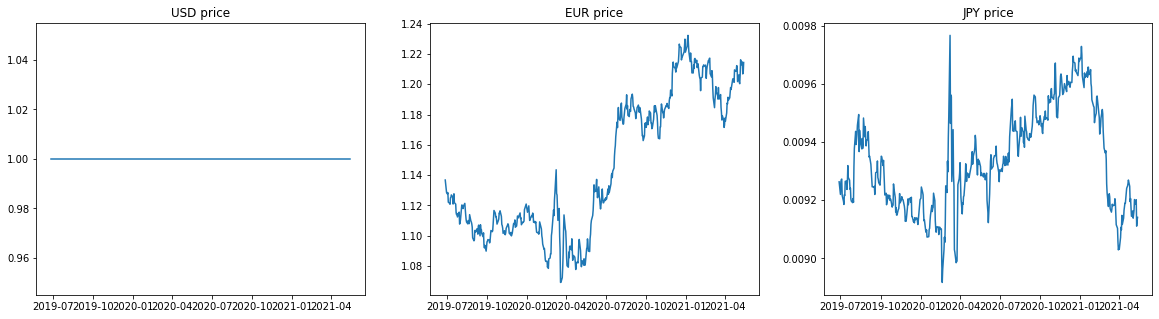

In [ ]:
# Importing libraries
import math
# Assign variables to the y axis part of the curve
y1 = fx_prices.iloc[:,0]
y2 = fx_prices.iloc[:,1]
y3 = fx_prices.iloc[:,2]

figure, axis = plt.subplots(1,3,figsize=(20,5))

axis[0].plot(y1)
axis[0].set_title("USD price")
  
# For Cosine Function
axis[1].plot(y2)
axis[1].set_title("EUR price")
  
# For Tangent Function
axis[2].plot(y3)
axis[2].set_title("JPY price")

plt.show()

In [ ]:
#compute returns dataframe
fx_returns_mat = np.zeros([num_timesteps,num_curncy])
for t in range(1,num_timesteps):
  for cur in curncy_list:
    index = curncy_list.index(cur)
    x = returns(cur,t)
    fx_returns_mat[t][index] = x
fx_returns = pd.DataFrame(fx_returns_mat, index=fx_px_df.index, columns = ['USD','EUR','JPY'])

In [ ]:
fx_returns

,USD,EUR,JPY
2019-06-27 21:00:00+00:00,0.0,0.000000,0.000000
2019-06-30 21:00:00+00:00,0.0,-0.007275,-0.004665
2019-07-01 21:00:00+00:00,0.0,0.000044,0.004669
2019-07-02 21:00:00+00:00,0.0,-0.000948,0.000872
2019-07-03 21:00:00+00:00,0.0,0.000825,0.000176
...,...,...,...
2021-05-09 21:00:00+00:00,0.0,-0.002804,-0.001800
2021-05-10 21:00:00+00:00,0.0,0.001633,0.001712
2021-05-11 21:00:00+00:00,0.0,-0.006495,-0.009849
2021-05-12 21:00:00+00:00,0.0,0.000671,0.002118


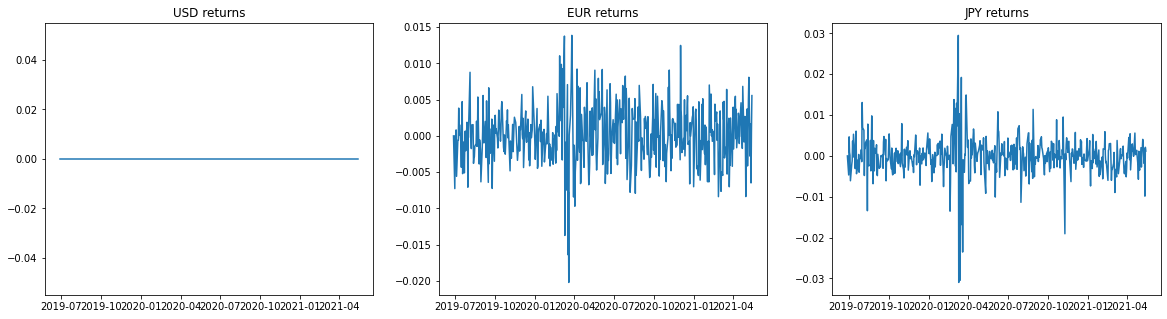

In [ ]:
#plot the returns
z1 = fx_returns.iloc[:,0]
z2 = fx_returns.iloc[:,1]
z3 = fx_returns.iloc[:,2]

figure, axis = plt.subplots(1,3,figsize=(20,5))

axis[0].plot(z1)
axis[0].set_title("USD returns")
  
# For Cosine Function
axis[1].plot(z2)
axis[1].set_title("EUR returns")
  
# For Tangent Function
axis[2].plot(z3)
axis[2].set_title("JPY returns")

plt.show()

In [ ]:
# calculate the cvxopt matrix
#calculate the objective function q
q_0 = np.zeros([num_timesteps*num_curncy,1])
add = np.ones([num_timesteps*num_curncy,1])
for t in range(1,num_timesteps):
  for cur in curncy_list:
    index = curncy_list.index(cur)
    x = returns(cur,t)
    q_0[t*num_curncy+index][0] = x
q = -add-q_0


In [ ]:
#build equality constraints
#matrix A
A = np.zeros([num_timesteps,num_curncy*num_timesteps])   
for t in range(num_timesteps):
  for k in range(num_curncy):
    A[t][t*num_curncy + k] = 1
#matrix b
b = np.ones([num_timesteps,1])

In [ ]:
#build inequality constraints
I = np.identity(num_curncy*num_timesteps)
P=np.vstack((I,-I))
h1 = np.ones([num_curncy*num_timesteps,1])
h2 = np.zeros([num_curncy*num_timesteps,1])
h = np.vstack((h1,h2))

##Optimisation problem formulation
We can choose to formulate the problem as following:
\begin{equation}
\tag 1
max_{X} \sum_{t=\tau}^{t=\tau + T} <1 + r_{t}, x_{t}>
\end{equation}
\begin{equation}
\tag 2
s.t \quad \| x_{t}\| = 1
\end{equation}
where $r_{t}$ is the vector that contains all of the returns computed at time step $t$ and $x_{t}$ are the portfolio weigths at time step $t$.

In [ ]:
# fin the objective function q
q_cvx = cvxopt.matrix(q)
#equality constraints
A_cvx = cvxopt.matrix(A)
b_cvx = cvxopt.matrix(b)
#inequality constraints
P_cvx = cvxopt.matrix(P)
h_cvx = cvxopt.matrix(h)
#optimize it
cvxopt_lp = cvxopt.solvers.lp(q_cvx,P_cvx,h_cvx,A_cvx,b_cvx, solver='glpk')
#calculate the terminal wealth
cvxopt_path = np.array(cvxopt_lp['x'])
last_layer_price = np.zeros([num_curncy,1])
for cur in curncy_list:
    index = curncy_list.index(cur)
    x = asset_price(cur,t,fx_px_df)
    last_layer_price[index][0] = x
last_layer_portfolio_weights = cvxopt_path[-num_curncy]

In [ ]:
#calculate the terminal wealth
cvxopt_path = np.array(cvxopt_lp['x'])
last_layer_price = np.zeros([num_curncy,1])
for cur in curncy_list:
    index = curncy_list.index(cur)
    x = asset_price(cur,t,fx_px_df)
    last_layer_price[index][0] = x
last_layer_portfolio_weights = cvxopt_path[len(cvxopt_path)-num_curncy:]

In [ ]:
np.dot(np.transpose(last_layer_price),last_layer_portfolio_weights)

array([[1.21439]])

In [ ]:
def layer_returns(t,path):
  portfolio_weights = path[t*num_curncy:t*num_curncy+3]
  portfolio_prices = np.zeros([num_curncy,1])
  
  for cur in curncy_list:
    index = curncy_list.index(cur)
    x = asset_price(cur,t,fx_px_df)
    portfolio_prices[index][0] = x
  return np.dot(np.transpose(portfolio_prices),portfolio_weights)

In [ ]:
portfolio_value_vector = np.zeros([num_timesteps,1])
for t in range(num_timesteps):
  x = layer_returns(t,cvxopt_path)
  portfolio_value_vector[t][0] = x
time = range(num_timesteps)

plt.figure(figsize=(10, 10))
display(plt.plot(time, portfolio_value_vector))

#A more complex framework for optimisation
In this case we are talking about optimising:
\begin{equation}
\tag 1
max_{X} \sum_{t=\tau}^{t=\tau + T} <1 + r_{t}, x_{t}>
\end{equation}
\begin{equation}
\tag 2
s.t \quad \| x_{t}\| = 1
\end{equation}

In [ ]:
best_mut_3_10 = np.array([0.76143632, 0.16068017, 0.14951949, 0.89362166, 0.55156742,
       0.68873079, 0.38004165, 0.39419877, 0.95667183, 0.45605023,
       0.5833262 , 0.96298179, 0.93273985, 0.76389432, 0.21681611,
       0.59230512, 0.67927673, 0.01769322, 0.87323689, 0.18927572,
       0.26043965, 0.72701672, 0.60172527, 0.84330645, 0.40805328,
       0.88967088, 0.43735475, 0.74860236, 0.68066934, 0.38953048,
       0.44197152, 0.25879707, 0.65930033, 0.90363722, 0.66603744,
       0.38886806, 0.67624221, 0.81800265, 0.95297957, 0.80505167,
       0.95999748, 0.66966365, 0.09804604, 0.79097383, 0.57744593,
       0.66517967, 0.09428037, 0.40510296, 0.92961028, 0.01010833,
       0.35837515, 0.46278558, 0.92421403, 0.74933867, 0.52427928,
       0.78375706, 0.76402892, 0.14119404, 0.72955787, 0.43567841,
       0.19846535, 0.12600164, 0.45947322, 0.40842859, 0.70811554,
       0.7793105 , 0.91908969, 0.43633571, 0.83584494, 0.07146316,
       0.41449353, 0.9025915 , 0.23662624, 0.90067933, 0.34769398,
       0.86254765, 0.36018853, 0.41952387, 0.34168894, 0.18086143,
       0.95513956, 0.36074831, 0.7229709 , 0.71030537, 0.90879255,
       0.59083758, 0.01862065, 0.89859495, 0.36424317, 0.33712237])

In [ ]:
def linprog_constraints(num_timesteps, num_curncy):
    
    #build the arc-incidence matrix for Kirchoff laws
    
    b = np.zeros((num_timesteps+1)*num_curncy)
    b[0] = -1
    b[-num_curncy] = 1
    A = np.zeros(((num_timesteps+1)*num_curncy,num_timesteps*num_curncy**2))
    for t in range(num_timesteps):
        for curncy_1 in range(num_curncy):
            for curncy_2 in range(num_curncy):
                A[t*num_curncy+curncy_1,t*num_curncy**2+curncy_1*num_curncy+curncy_2] = -1
                A[(t+1)*num_curncy+curncy_2,t*num_curncy**2+curncy_1*num_curncy+curncy_2] = 1
    return A, b

# Building CVXOPT constraints
def cvxopt_constraints(A, b):
    
    #add the flow constraints to your model according to the Kirchoff laws.
    
    cvxopt_A = np.vstack((A,-A))
    cvxopt_A = np.vstack((cvxopt_A,-np.eye(cvxopt_A.shape[1])))
    cvxopt_A = np.vstack((cvxopt_A,np.eye(cvxopt_A.shape[1])))
    cvxopt_b = np.hstack((b,-b))
    cvxopt_b = np.hstack((cvxopt_b,np.zeros(cvxopt_A.shape[1])))
    
    #build the total set of constraints for the model that combines both Kirchoff laws 
    #and the capacity constraints on the network
    mut=best_mut_3_10
    cvxopt_b = np.hstack((cvxopt_b,mut))
    return cvxopt.matrix(cvxopt_A), cvxopt.matrix(cvxopt_b),mut

# Preparations for CVXOPT
#calculate the costs for your network
fx_dist_array = -np.log(fx_px.flatten())
fx_px_df = pd.DataFrame(fx_px, fx_px_df.index,fx_px_df.columns)
fx_px_graph_mtrx = fx_px_to_graph(fx_px_df, ['USD','EUR','JPY'])
#calculate the equivalence matrices
A_eq, b_eq = linprog_constraints(num_timesteps,num_curncy)
A_cvxopt, b_cvxopt, MUT = cvxopt_constraints(A_eq,b_eq)
cvxopt_fx_dist_array = cvxopt.matrix(fx_dist_array)
#measure the run-time
begin_time = time.time()
cvxopt_lp = cvxopt.solvers.lp(cvxopt_fx_dist_array,A_cvxopt,b_cvxopt, solver='glpk')
cvxopt_path = np.array(cvxopt_lp['x'])
lin_prog_test_time = time.time()-begin_time
cvxopt_result = np.dot(fx_dist_array,cvxopt_path)
print("CVXOPT Test: 1 In, {out} Out. Used time: {used_time}".format(
    out = np.exp(-cvxopt_result[0]), used_time = lin_prog_test_time))
weight_mtrx_cvxopt = pd.DataFrame(cvxopt_path.reshape((num_timesteps,num_curncy**2)), index = fx_px_df.index, columns = fx_px_df.columns)
weight_mtrx_cvxopt = fx_px_to_graph(weight_mtrx_cvxopt, curncy_list)

# Plots the problem in directed graph with the optimal solution


#Predict the FX rates


In [ ]:
usd_eur_df = fx_px_df.iloc[:,1]

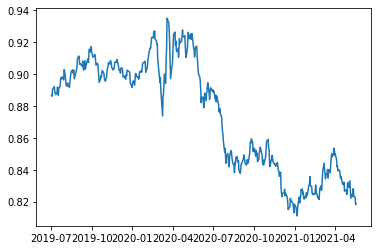

In [ ]:
plt.plot(usd_eur_df)

In [ ]:

adf_test = adfuller(usd_eur_df)
print('stat=%.3f, p=%.3f' % adf_test[0:2])
if adf_test[1] > 0.05:
 print('Probably not Stationary')
else:
 print('Probably Stationary')

stat=-0.514, p=0.889
Probably not Stationary


In [ ]:

kpss_test = kpss(usd_eur_df, nlags='auto')
print('stat=%.3f, p=%.3f' % kpss_test[0:2])
if kpss_test[1] > 0.05:
    print('Probably Stationary')
else:
    print('Probably not Stationary')


stat=3.118, p=0.010
Probably not Stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


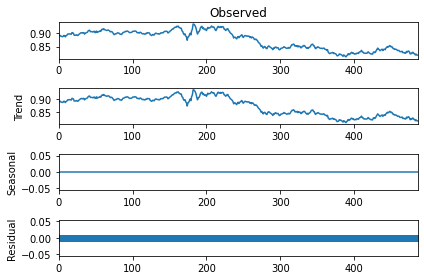

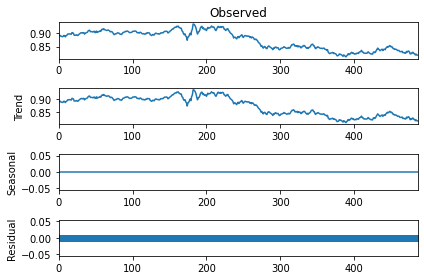

In [ ]:

y_pred_list = usd_eur_df.tolist()
result = seasonal_decompose(y_pred_list, model='additive', period=1)
result.plot()

In [ ]:
stat_fx_log = np.log(usd_eur_df)
stat_fx_log_diff = stat_fx_log - stat_fx_log.shift(1)
stat_fx_log_diff.dropna(inplace=True)

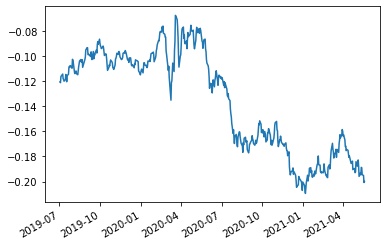

In [ ]:
stat_fx_log.plot()

In [ ]:
import itertools
p = range(1, 5)
d = range(1, 2)
q = range(1, 5)
k = 0
pdq = list(itertools.product(p, d, q))
aics = np.zeros(25)
for param in pdq:
    model = ARIMA(stat_fx_log, order=param)
    model_fit = model.fit()
    aic = model_fit.aic
    aics[k] = aic
    k=k+1
combo = list(zip(aics, params))
combo.sort()
combo_array = np.array(combo)
print(combo_array)


NameError: ignored

In [ ]:
%%capture
import itertools
p = range(1, 4)
d = range(1, 2)
q = range(1, 3)
pq = list(itertools.product(p, d, q))
aics = []
params = []
for param in pq:
    model = ARIMA(stat_fx_log, order=param)
    model_fit = model.fit()
    aic = model_fit.aic
    aics.append(aic)
    params.append(param)
combo = list(zip(aics, params))
combo.sort()
combo_array = np.array(combo)
print(combo_array)

In [ ]:
combo_array

array([[-3966.1342316973764, (3, 1, 1)],
       [-3964.2374166815202, (3, 1, 2)],
       [-3964.070464336826, (1, 1, 2)],
       [-3963.197237814025, (2, 1, 2)],
       [-3962.74105453135, (2, 1, 1)],
       [-3961.319733435447, (1, 1, 1)]], dtype=object)

AttributeError: ignored

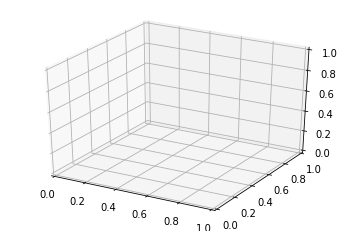

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(p, q, aics, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface')

In [ ]:
aics.shape

AttributeError: ignored

In [ ]:
%%capture
#write a function that will predict a new data point based on arima model and do this for the next 10 data points
k = 5
train_data = stat_fx_log[:len(stat_fx_log)-k]
predicted_data = train_data
x = np.zeros(k)
for i in range(k):
  model_1 = ARIMA(predicted_data, order=[3,1,2])
  model_fit_1 = model_1.fit()
  x[i] = model_fit_1.forecast(1, alpha=0.05)[0]
  x_pd = pd.Series(x[i])
  predicted_data = predicted_data.append(x_pd)

In [ ]:
%%capture
forecasted_data = stat_fx_log[:len(stat_fx_log)-k]
model_2 = ARIMA(stat_fx_log[:len(stat_fx_log)-k], order=[3,1,2])
model_fit_2 = model_2.fit()
y_pred = model_fit_2.forecast(k, alpha=0.05)[0]
y_pred_pd = pd.Series(y_pred)
forecasted_data = forecasted_data.append(y_pred_pd)

In [ ]:
y_pred - x

array([ 0.00000000e+00,  1.42879447e-05, -1.42721269e-05, -5.02328598e-05,
       -9.01520068e-05])

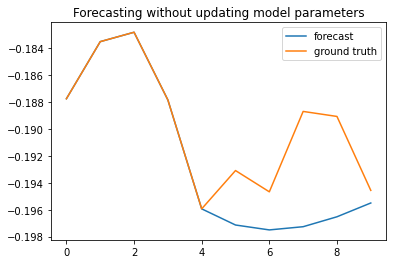

In [ ]:
plt.plot(forecasted_data.values[-k-5:], label='forecast')
plt.plot(stat_fx_log.values[-k-5:], label = 'ground truth')
plt.legend()
plt.title('Forecasting without updating model parameters')
plt.show()

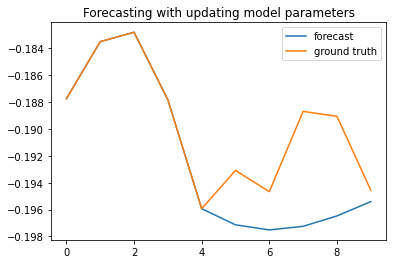

In [ ]:
plt.plot(predicted_data.values[-k-5:], label='forecast')
plt.plot(stat_fx_log.values[-k-5:], label = 'ground truth')
plt.legend()
plt.title('Forecasting with updating model parameters')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
test = stat_fx_log[len(stat_fx_log)-k:]
rmse_1 = sqrt(mean_squared_error(test, x))
rmse_2 = sqrt(mean_squared_error(test, y_pred))

In [ ]:
%%capture
rmse_1= np.zeros(50)
ind =0
rmse_2 = np.zeros(50)
for k in range(2,50,5):
  train_data = stat_fx_log[:len(stat_fx_log)-k]
  predicted_data = train_data 
  x = np.zeros(k)
  for i in range(k):
    model_1 = ARIMA(predicted_data, order=[3,1,2])
    model_fit_1 = model_1.fit()
    x[i] = model_fit_1.forecast(1, alpha=0.05)[0]
    x_pd = pd.Series(x[i])
    predicted_data = predicted_data.append(x_pd)
  forecasted_data = stat_fx_log[:len(stat_fx_log)-k]
  model_2 = ARIMA(stat_fx_log[:len(stat_fx_log)-k], order=[3,1,2])
  model_fit_2 = model_2.fit()
  y_pred = model_fit_2.forecast(k, alpha=0.05)[0]
  y_pred_pd = pd.Series(y_pred)
  forecasted_data = forecasted_data.append(y_pred_pd)
  test = usd_eur_df[len(stat_fx_log)-k:]
  rmse_1[ind] = sqrt(mean_squared_error(test, np.exp(x))) * 100
  rmse_2[ind] = sqrt(mean_squared_error(test, np.exp(y_pred))) * 100
  ind = ind+1

Text(0.5, 1.0, 'Forecasting Error')

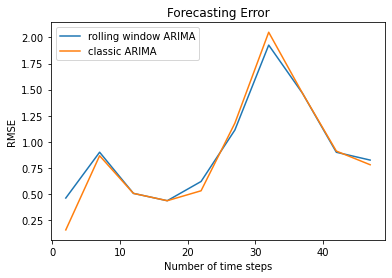

In [ ]:
x = [2,7,12,17,22,27,32,37,42,47]
plt.plot(x,rmse_1[:10], label = 'rolling window ARIMA')
plt.plot(x,rmse_2[:10], label = 'classic ARIMA')
plt.xlabel("Number of time steps")
plt.ylabel("RMSE")
plt.legend()
plt.title("Forecasting Error")

Text(0.5, 1.0, 'USD/EUR forecast')

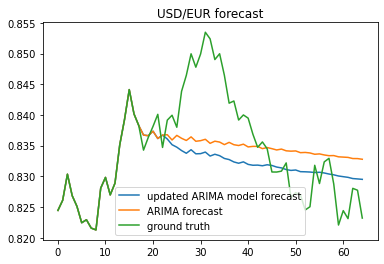

In [ ]:
plt.plot(np.exp(predicted_data)[-65:].values, label= 'updated ARIMA model forecast')
plt.plot(np.exp(forecasted_data)[-65:].values, label = 'ARIMA forecast')
plt.plot(usd_eur_df[-65:].values, label = 'ground truth')
plt.legend()
plt.title('USD/EUR forecast')


In [ ]:
pred.shape

(1,)

In [ ]:
import itertools

In [ ]:
usd_jpy_df = fx_px_df.iloc[:,2]
eur_usd_df = fx_px_df.iloc[:,3]
eur_jpy_df = fx_px_df.iloc[:,5]
jpy_usd_df = fx_px_df.iloc[:,6]
jpy_eur_df = fx_px_df.iloc[:,7]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
predict_exchange_rates(usd_jpy_df,10)

In [ ]:
%%capture
k = 10
train_data = stat_fx_log[:len(stat_fx_log)-k]
save_data = stat_fx_log[:len(stat_fx_log)-k]
predicted_data = train_data 
N_train = len(train_data)
look1 = np.zeros(k)
look2 = np.zeros(k)
look3 = np.zeros(k)
look4 =  np.zeros(k)
ind = 0
for i in range(k):
  model_1 = ARIMA(train_data, order=[3,1,2])
  model_fit_1 = model_1.fit()
  predicted_days = model_fit_1.forecast(4, alpha=0.05)[0]
  look1[ind] = predicted_days[0]
  look2[ind] = predicted_days[1]
  look3[ind] = predicted_days[2]
  look4[ind] = predicted_days[3]
  ind = ind+1
  train_data = stat_fx_log[:len(stat_fx_log)-k+i]
look_1_predict = save_data
look_2_predict = save_data
look_3_predict = save_data
look_4_predict = save_data
look1 = pd.Series(look1, index = fx_px_df.index)
look2= pd.Series(look2, index = fx_px_df.index)
look3 = pd.Series(look3, index = fx_px_df.index)
look4= pd.Series(look4, index = fx_px_df.index)
look_1_predict = look_1_predict.append(look1)
look_2_predict = look_2_predict.append(look2)
look_3_predict = look_3_predict.append(look3)
look_4_predict = look_4_predict.append(look4)


NameError: ignored

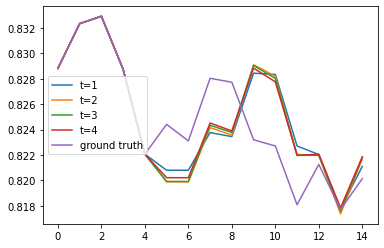

In [ ]:
plt.plot(np.exp(look_1_predict[-k-5:]).values, label ='t=1')
plt.plot(np.exp(look_2_predict[-k-5:]).values, label = 't=2')
plt.plot(np.exp(look_3_predict[-k-5:]).values, label = 't=3')
plt.plot(np.exp(look_4_predict[-k-5:]).values, label = 't=4')
plt.plot(usd_eur_df[-k-5:].values,label = 'ground truth')
plt.legend()
plt.show()

In [ ]:
type(look1)

NameError: ignored